In [114]:
import numpy as np
import pandas as pd
import praw
import time
from pmaw import PushshiftAPI
import openai
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import nltk
from statistics import mean
from sklearn import metrics

In [4]:
df = pd.read_csv("combined_data_for_use.csv", index_col=0)

In [5]:
df.sample(n=20)

,question,ai_answer,human_answer
2217,Has teen acne been around since prehistoric ti...,\n\nThere is no definitive answer to this ques...,"Based on responses here it made me wonder, are..."
5003,Which U.S. president faced the greatest challe...,\n\nThe easiest term to choose would be George...,This is a subjective question so history as a ...
3052,Can the back action propagation in a neuron sp...,"\n\nNo, the back action propagation in a neuro...",I haven't heard of a case where depolarization...
3339,Is there empirical evidence for the existence ...,\n\nThere is some empirical evidence for the e...,Yes and no.\n\nWe're aware of pathways and cir...
5428,Why did not Europeans use American weapons dur...,\n\nThere are a few reasons why Europeans did ...,The United States was not the industrial power...
3013,Why can't humans contract certain viruses from...,\n\nThere is no known way for humans to contra...,[removed]
4567,Even if we assume that ALL of the facts in Gun...,"\n\nYes, the basic idea is still valid.",when I took a class in the High Middle Ages (s...
988,What is the brutal reality of tech for someone...,\n\nThere is the brutal reality of tech for so...,You are seeing the greener grass on the other ...
2470,Why do we all have different voices?,\n\nThis is a difficult question. Some people ...,We all have different bodies and brains. Diffe...
3906,Honest answer why I want a new job during inte...,\n\nThere are many reasons why someone might w...,I've said it before. It was less direct but th...


## EDA and pre-processing

In [6]:
#how many questions are questions?
count_q = 0
for t in df["question"]:
    if "?" in t:
        count_q +=1
print(count_q)
print(count_q/len(df))

4877
0.8830345826543545


In [7]:
#how many words on average are in the responses (ai vs human)
count_words = [len(nltk.word_tokenize(p)) for p in df["ai_answer"]]
mean(count_words)

45.58917255114974

In [8]:
mean(df['ai_answer'].str.len())

234.3706319029513

In [9]:
mean(df['human_answer'].str.len())

673.4162592793772

In [10]:
count_words = [len(nltk.word_tokenize(p)) for p in df["human_answer"]]
mean(count_words)

130.36212203512585

In [11]:
# remove rows with 1 word responses: [deleted] , [removed]
# may want to research why these showed up as top comments

In [12]:
df_filtered_ = df[df["human_answer"] != "[deleted]"]
df_filtered_ = df[df["human_answer"] != "[removed]"]

In [13]:
df_filtered_["question"] = [t if "?" in t else 0 for t in df_filtered_["question"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_89377/3015071509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_["question"] = [t if "?" in t else 0 for t in df_filtered_["question"]]


In [14]:
df_filtered_["is_human"] = [0 if i != "" else 1 for i in df_filtered_["human_answer"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_89377/2411922918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_["is_human"] = [0 if i != "" else 1 for i in df_filtered_["human_answer"]]


In [15]:
df_filtered_["is_ai"] = [1 if i != "" else 0 for i in df_filtered_["ai_answer"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_89377/3279253241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_["is_ai"] = [1 if i != "" else 0 for i in df_filtered_["ai_answer"]]


In [16]:
df_filtered_["question_dubs"] = df_filtered_["question"]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_89377/4270538928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_["question_dubs"] = df_filtered_["question"]


In [17]:
df_filtered_.head()

,question,ai_answer,human_answer,is_human,is_ai,question_dubs
0,Redditors who make +$100K and aren’t being kil...,\n\nSome Redditors who make +$100K and aren’t ...,If that’s important to you then not working at...,0,1,Redditors who make +$100K and aren’t being kil...
1,Quitting after 8 years without notice. Am I wr...,"\n\nYes, you are wrong. You are allowed to qui...",You are not wrong.\nLoyalty is a two-way stree...,0,1,Quitting after 8 years without notice. Am I wr...
2,My boss is pressuring to tell him where my new...,\n\nIf you are in a position of authority and ...,No. Do not say anything to him. Managers are n...,0,1,My boss is pressuring to tell him where my new...
3,"BS’ed my way into a 160K job offer, am I crazy...",\n\nThere is no definitive answer to this ques...,Literally every single person I've known who e...,0,1,"BS’ed my way into a 160K job offer, am I crazy..."
4,My boss confronted me about only working 7 hou...,\n\nIf your boss confronts you about working o...,Work an extra 15 minutes and tell him you didn...,0,1,My boss confronted me about only working 7 hou...


In [18]:
df_consolidated_ = df_filtered_[['question', 'human_answer', "is_human"]].append(df_filtered_[[
    'question_dubs','ai_answer',"is_ai"]].set_axis(['question', 'human_answer',"is_human"], axis=1)).reset_index(drop=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_89377/2681310793.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated_ = df_filtered_[['question', 'human_answer', "is_human"]].append(df_filtered_[[


In [19]:
df_consolidated_.rename(columns={"human_answer": "answer"}, inplace=True)

In [20]:
#remove phrases that would give away AI answer
df_consolidated_.loc[df_consolidated_["is_human"] == 1, "answer"] = df_consolidated_["answer"].str.replace("I am only a machine", "")
df_consolidated_.loc[df_consolidated_["is_human"] == 1, "answer"] = df_consolidated_["answer"].str.replace("As an AI language model", "")

In [21]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk

 
nltk_stop = stopwords.words('english')

In [22]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [23]:
#split answers into tokens(words)
df_consolidated_splits = df_consolidated_["answer"].apply(nltk.word_tokenize)

In [24]:
#lemmatize and rejoin tokens for each answer
for i in range(len(df_consolidated_splits)):
    df_consolidated_splits[i] = ' '.join([lemmatizer.lemmatize(w) for w in df_consolidated_splits[i]])

In [25]:
df_consolidated_splits.head()

0    If that ’ s important to you then not working ...
1    You are not wrong . Loyalty is a two-way stree...
2    No . Do not say anything to him . Managers are...
3    Literally every single person I 've known who ...
4    Work an extra 15 minute and tell him you didn ...
Name: answer, dtype: object

In [26]:
df_consolidated_["answer"] = df_consolidated_splits

## Modeling

In [27]:
X = df_consolidated_["answer"]
y = df_consolidated_["is_human"]

In [28]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

### Bernoulli

#### Count Vectorizer

In [29]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [30]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english', nltk_stop],
}

In [31]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [32]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [33]:
gs.best_score_

0.7910725356478612

In [34]:
print(gs.score(X_train,y_train))
print(gs.score(X_test,y_test))


0.8040917544947304
0.7958348828560803


#### TFIDF

In [35]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english', nltk_stop]
}

In [36]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [37]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [38]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [39]:
gs_tvec.best_score_

0.7910725356478612

In [40]:
print(gs_tvec.score(X_train,y_train))
print(gs_tvec.score(X_test,y_test))

0.8040917544947304
0.7958348828560803


### Multinomial

#### Count Vectorizer

In [51]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [52]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english', nltk_stop],
}

In [53]:
gs_mnb = GridSearchCV(pipe_mnb, 
                  pipe_params, 
                  cv = 5)

In [54]:
gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [55]:
gs_mnb.best_score_

0.7791692498450093

In [56]:
print(gs_mnb.score(X_train,y_train))
print(gs_mnb.score(X_test,y_test))


0.8233106013639182
0.766827817032354


#### TFIDF

In [57]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english', nltk_stop]
}

In [58]:
pipe_tvec_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [59]:
gs_tvec_mnb = GridSearchCV(pipe_tvec_mnb, 
                  pipe_params_tvec, 
                  cv = 5)

In [60]:
gs_tvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [61]:
gs_tvec_mnb.best_score_

0.8367017978921266

In [62]:
print(gs_tvec_mnb.score(X_train,y_train))
print(gs_tvec_mnb.score(X_test,y_test))

0.9013019218846869
0.8382298252138342


### Logistic Regression

#### Count Vectorizer

In [64]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [65]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english', nltk_stop],
}

In [66]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [67]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [69]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_test,y_test))

0.986360818350899
0.8813685384901451


In [68]:
gs_logr.best_score_

0.8745195288282706

#### TFIDF

In [70]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [71]:
pipe_params_ = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english', nltk_stop]
}

In [77]:
gs_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                  pipe_params_, 
                  cv = 5)

In [78]:
gs_tvec_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [79]:
print(gs_tvec_logr.score(X_train,y_train))
print(gs_tvec_logr.score(X_test,y_test))

0.992684438933664
0.8873187058386017


In [80]:
gs_tvec_logr.best_score_

0.8841909485430873

### Random Forest

In [ ]:

Random Forest
KNN


In [ ]:
#consider splitting by reddit thread
#consider sorting by shorter/longer questions
#consider filtering by token counts in human_answers, to align with ai limits
#consider looking at test data, predictions, whether predictions are different from y, and correlating that to question length and subreddit

### Decision Tree

In [81]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [82]:
dtc = DecisionTreeClassifier()

In [84]:
dt = dtc.fit(X_train_cv, y_train)

In [85]:
print(dt.score(X_train_cv, y_train))
print(dt.score(X_test_cv, y_test))

0.9997520148791073
0.8218668650055783


### Random Forest

#### Count Vectorizer

In [102]:
rf = RandomForestClassifier()

In [103]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [104]:
print(gs_dt.best_score_)
print(gs_dt.best_params_)

0.9024178549287043
{'max_depth': None, 'n_estimators': 150}


In [106]:
gs_dt.best_estimator_

RandomForestClassifier(n_estimators=150)

In [107]:
gs_dt.score(X_test_cv, y_test)

0.8988471550762365

#### TFIDF

In [109]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec.fit(X_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [110]:
print(gs_dt_tvec.best_score_)
print(gs_dt_tvec.best_params_)

0.8996900185988841
{'max_depth': None, 'n_estimators': 200}


In [111]:
gs_dt_tvec.best_estimator_

RandomForestClassifier(n_estimators=200)

In [112]:
gs_dt_tvec.score(X_test_tv, y_test)

0.8973596132391224

### ADA Boost

#### Count Vectorizer + Logistic Regression

In [83]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [86]:
abc = AdaBoostClassifier(random_state = 42)

In [87]:
dt_abc = abc.fit(X_train_cv, y_train)

In [88]:
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.8514569125852449
0.832651543324656


In [89]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.8833230006199628
0.8571959836370397


In [90]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.9861128332300062
0.894384529564894


In [91]:
abc_logreg = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg.fit(X_train_cv, y_train)
abc_logreg.score(X_train_cv, y_train)
abc_logreg.score(X_test_cv, y_test)

0.8995909259947936

#### TFIDF + Logistic Regression

In [92]:
tv = TfidfVectorizer(min_df=2)
tv.fit(X_train)

X_train_tv = tv.transform(X_train)
X_test_tv = tv.transform(X_test)

In [93]:
abc = AdaBoostClassifier(random_state = 42)

In [94]:
dt_abc_tv = abc.fit(X_train_tv, y_train)

In [96]:
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.8659640421574706
0.8426924507251766


In [97]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.8912585244885307
0.8590554109334325


In [98]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.9993800371977681
0.894384529564894


In [99]:
abc_logreg_tv = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg_tv.fit(X_train_tv, y_train)
abc_logreg_tv.score(X_train_tv, y_train)
abc_logreg_tv.score(X_test_tv, y_test)

0.8519895872071402

In [48]:
# Get predictions
preds = gs.predict(X_test)

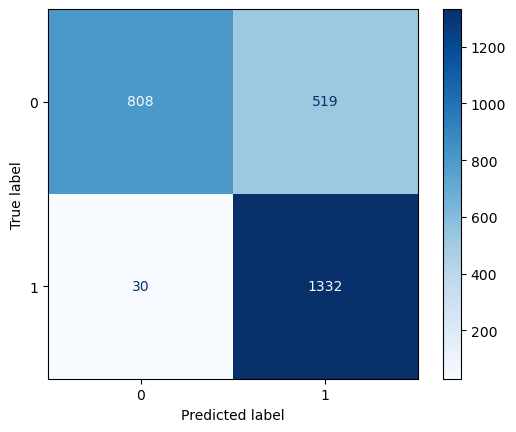

In [42]:

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues', values_format='d');

In [50]:
def find_cm(preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}")
    
    #return tn, fp, fn, tp

find_cm(preds)

TN: 808
FP: 519
FN: 30
TP: 1332
Sensitivity: 0.9779735682819384
Specificity: 0.6088922381311228


In [ ]:
#look at filtered data - where human token count is <=300 (to match ai)
#look at doing analysis for each question type
#look at doing analysis based on how long the question is